In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import scipy.io as scio
import scipy.optimize as optimize
import random
import pandas as pd
import warnings

In [2]:
mat = scio.loadmat('ex5data1.mat')
# training set
X, Y = mat['X'], mat['y']
# cross validation
Xval, Yval = mat['Xval'], mat['yval']
# cross validation
Xtest, Ytest = mat['Xtest'], mat['ytest']

# insert a column of 1's to all of the X's
X = np.insert(X, 0, 1, axis=1)
Xval = np.insert(Xval, 0, 1, axis=1)
Xtest = np.insert(Xtest, 0, 1, axis=1)

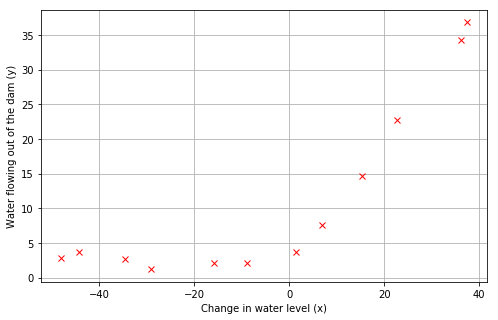

In [3]:
def plotData():
    plt.figure(figsize=(8,5))
    plt.plot(X[:,1], Y, 'rx')
    plt.ylabel('Water flowing out of the dam (y)')
    plt.xlabel('Change in water level (x)')
    plt.grid(True)
    
plotData()

In [4]:
# hypothesis function h => linear regression
def h(theta, X):
    return np.dot(X, theta)

In [5]:
# regularized linear regression cost function

# global variables

# cost function => ComputeCost
def computeCost(theta, X, Y, Lambda=0.):

    m = X.shape[0] # samples num's
    
    # 1/2m * sum ((hø(x)-y)^2) + lambda/2m * sum(øj^2)
    hs = h(theta, X).reshape((m,1))
    cost_term = float(1 / (2*m) * np.dot((hs-Y).T, hs-Y)) 
    reg_term = float(Lambda / (2*m) * np.dot(theta[1:].T, theta[1:]))
    
    return cost_term + reg_term
    

In [6]:
theta_t = np.array([[1.], [1.]])
print (computeCost(theta_t, X, Y))


303.9515255535976


In [7]:
# axes_0 => row, axes_1 => col
def reshapeParams(params, axex_0, axes_1):
    return params.reshape((params.shape[axex_0], axes_1))

In [8]:
mytheta = np.array([[1.], [1.]])
print (reshapeParams(mytheta, 0, 1))

[[1.]
 [1.]]


In [9]:
# regularized linear regression gradient

# the partial derivative of regularized linear regression’s cost for θj
# øj = øj - learning rate * derivative (J(ø))
def computeGradient(mytheta, myX, myy, mylambda=0.):
    
    mytheta = mytheta.reshape((mytheta.shape[0]), 1)
    m = myX.shape[0]

    #grad has same shape as myTheta (2x1)
    myh = h(mytheta, myX).reshape((m,1))
    grad = (1./float(m))*myX.T.dot(h(mytheta, myX)-myy) # J(ø) derivative term
    
    regterm = (float(mylambda)/m)*mytheta
    regterm[0] = 0 #don't regulate bias term
    regterm.reshape((grad.shape[0],1))
#     print (grad, regterm)
    return grad + regterm


In [10]:
# a wrapper for computeGradient that flattens the outputs
def computeGradientFlattened(theta, X, Y, Lambda=0.):
    return computeGradient(theta, X, Y, Lambda).flatten()

In [11]:
mytheta = np.array([[1.],[1.]])
print (computeGradient(mytheta, X, Y, 1.))

[[-15.30301567]
 [598.25074417]]


In [12]:
# fitting linear regression => optimize -> fmin_cg
def optimizeTheta(initial_theta, X, Y, Lambda=0., print_out=True):
    final_theta = optimize.fmin_cg(computeCost, x0=initial_theta, \
                                   fprime=computeGradientFlattened, \
                                   args=(X, Y, Lambda), \
                                   disp=print_out, \
                                   epsilon=1.49e-12, \
                                   maxiter=1000)
    final_theta = reshapeParams(final_theta, 0, 1)
    return final_theta
    

In [13]:
mytheta = np.array([[1.], [1.]])
fit_theta = optimizeTheta(mytheta, X, Y, 0.)

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


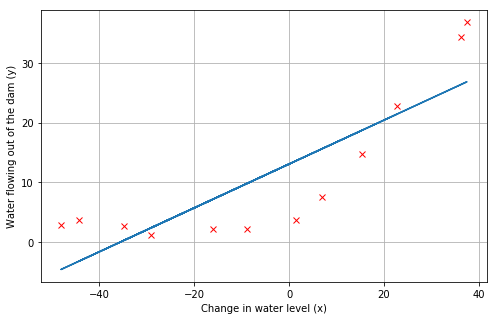

In [14]:
plotData()
plt.plot(X[:,1], h(fit_theta, X).flatten())

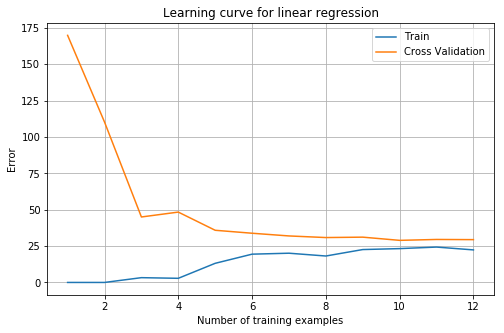

In [15]:
# bais, variance

# learning curve
def plotLearningCurve():
    """
    loop over first training point, then first 2 training points, then first 3 ...
    and use each training-set-subset to find trained parameters
    
    with those parameters, compute the cost on that subset(Jtrain)
    remembering that for Jtrain m, lambda=0(even if you are using regularization)
    
    then use the trained parameters to compute Jval on the entire valdidation set
    againg forcing lambda = 0 even if using regularization
    
    store the computed error, error_train and error_val and plot them
    """
    
    initial_theta = np.array([[1.], [1.]])
    mym, error_train, error_val = [], [], []
    
    # 取部分数据作为training set
    for i_row in range(1,13,1):
        train_subset = X[:i_row, :]
        y_subset = Y[:i_row]
        mym.append(y_subset.shape[0])
        
        fit_theta = optimizeTheta(initial_theta, train_subset, y_subset, Lambda=0., print_out=False)
        # 根据现有的theta，以及training set数据，获得min cost
        error_train.append(computeCost(fit_theta, train_subset, y_subset, Lambda=0.))
        # 根据现有的theta，以及cross validation set，获得min cost
        error_val.append(computeCost(fit_theta, Xval, Yval, Lambda=0.))
        
    # plot
    plt.figure(figsize=(8,5))
    plt.plot(mym, error_train, label="Train")
    plt.plot(mym, error_val, label="Cross Validation")
    plt.legend()
    plt.grid(True)
    plt.title('Learning curve for linear regression')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')

plotLearningCurve()


In [21]:
# polynomial regression
def genPolyFeature(X, p):
    """
    function takes in the X matrix (with bias term already included as the first column)
    and returns an X matrix with "p" additional columns.
    
    the first additinal column will be the 2nd column (first non-bias column) squared,
    the next additianl column will be the 2nd column cubed, etc,
    """
    # hθ (x) = θ0 + θ1 ∗ (waterLevel) + θ2 ∗ (waterLevel)2 + · · · + θp ∗ (waterLevel)p
    #        = θ0 +θ1x1 +θ2x2 +...+θpxp.
    new_X = X.copy()
    for i in range(p):
        dim = i+2
        new_X = np.insert(new_X, new_X.shape[1], np.power(new_X[:, 1], dim), axis=1)
    return new_X
        

In [31]:
def featureNormalize(X):
    """
    Takes as input the X array (with bias '1' first column), does
    feature normalizing on the columns (subtract mean, divide by standard deviation(std))
    
    returns the feature-normalizing X, and feature means and stds in a list
    """
    X_norm = X.copy()
    means = np.mean(X_norm, axis=0) # 每列的平均值 列 =》 axis=0
    stds = np.std(X_norm, axis=0, ddof=1)
    
    X_norm[:, 1:] = (X_norm[:, 1:] - means[1:]) / stds[1:]
    
    return X_norm, means, stds
    

In [32]:
# learing polynomial regression 

# generate an X matrix with terms up through x^8
# (7 additional coulumns to the X matrix)

global_d = 5 # a polynomial of degree
new_X = genPolyFeature(X, global_d)
X_norm, means, stds = featureNormalize(new_X)

# find fit parameters starting with 1's as the initial guess
initial_theta = np.ones((X_norm.shape[1], 1))
fit_theta = optimizeTheta(initial_theta, X_norm, Y, 0.)

Optimization terminated successfully.
         Current function value: 0.198053
         Iterations: 121
         Function evaluations: 234
         Gradient evaluations: 234


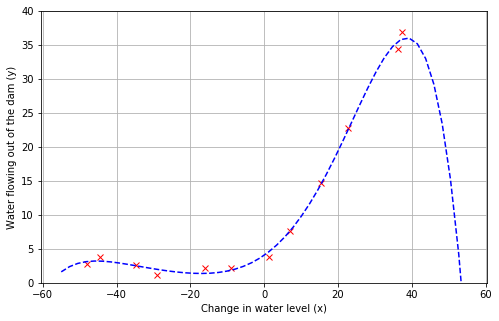

In [36]:
def plotFit(theta, means, stds):
    """
    function that takes in some learned fit values=>thetas(on feature-normalized data)
    
    it sets x-points as a linspace, constructs an appropriate X matrix,
    un-does previous feature normalization, computes the hypothesis values and plots on top of data
    """
    num_points = 50
    xvals = np.linspace(-55, 55, num_points)
    x_matrix = np.ones((num_points, 1))
    
    x_matrix = np.insert(x_matrix, x_matrix.shape[1], xvals.T, axis=1)
    x_matrix = genPolyFeature(x_matrix, len(fit_theta)-2)
    
    x_matrix[:, 1:] = (x_matrix[:, 1:] - means[1:]) / stds[1:]
    plotData()
#     print (fit_theta, h(fit_theta, x_matrix))
    plt.plot(xvals, h(fit_theta, x_matrix),'b--')
    plt.ylim([0,40])

plotFit(fit_theta, means, stds)  
    

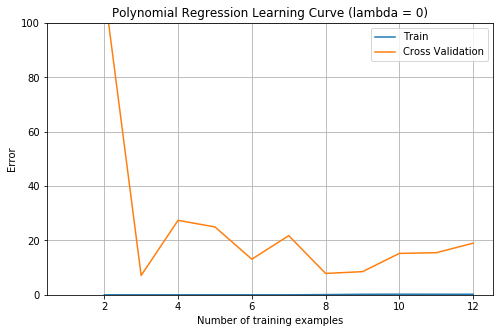

In [40]:
def plotPolyLearningCurve(myLambda=0.):
    
    initial_theta = np.ones((global_d+2, 1))
    mym, error_train, error_val = [], [], []
    myXval, dummy1, dummy2 = featureNormalize(genPolyFeature(Xval, global_d))
    
    for x in range(1,13,1):
        train_subset = X[:x, :]
        y_subset = Y[:x]
        mym.append(y_subset.shape[0])
        train_subset = genPolyFeature(train_subset, global_d)
        train_subset, dummy1, dummy2 = featureNormalize(train_subset)
        fit_theta = optimizeTheta(initial_theta, train_subset, y_subset, Lambda=myLambda, print_out=False)
        error_train.append(computeCost(fit_theta, train_subset, y_subset, Lambda=myLambda))
        error_val.append(computeCost(fit_theta, myXval, Yval, Lambda=myLambda))
    
    plt.figure(figsize=(8,5))
    plt.plot(mym, error_train, label='Train')
    plt.plot(mym, error_val, label='Cross Validation')
    plt.legend()
    plt.title('Polynomial Regression Learning Curve (lambda = 0)')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.ylim([0,100])
    plt.grid(True)
    
plotPolyLearningCurve() 

Optimization terminated successfully.
         Current function value: 7.338822
         Iterations: 14
         Function evaluations: 29
         Gradient evaluations: 29


/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:130: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


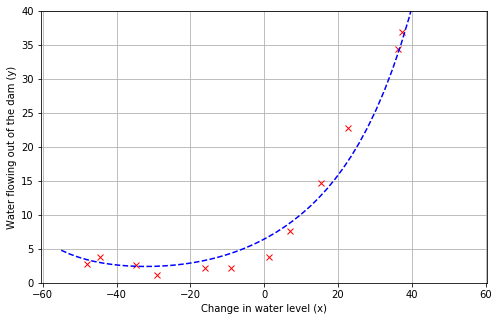

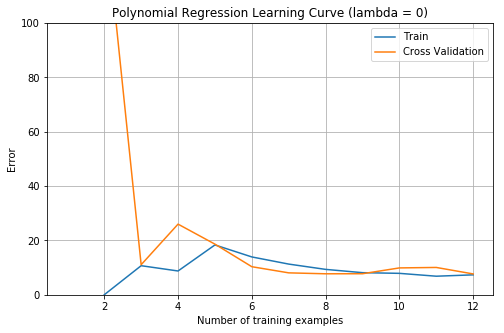

In [42]:
mytheta = np.zeros((X_norm.shape[1], 1))
fit_theta = optimizeTheta(mytheta, X_norm, Y, 1)
plotFit(fit_theta, means, stds)
plotPolyLearningCurve(1.)

Optimization terminated successfully.
         Current function value: 67.547554
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11


(-20, 40)

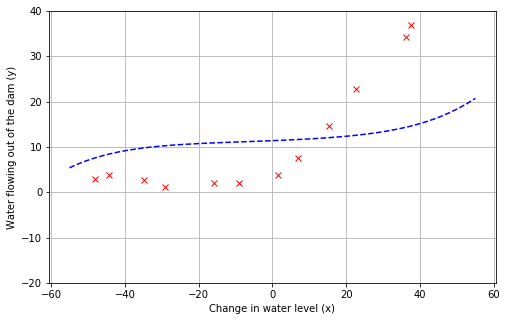

In [44]:
mytheta = np.random.rand(X_norm.shape[1],1)
fit_theta = optimizeTheta(mytheta, X_norm,Y,100.)
plotFit(fit_theta,means, stds)
plt.ylim(-20,40)


In [11]:
# print (Y.shape, X.shape)

mytheta = np.array([[2.],[1.]])
mytheta = mytheta.reshape((mytheta.shape[0]), 1)
print (mytheta.shape)

print (mytheta.flatten()) # => list

(2, 1)
[2. 1.]


In [53]:
for x in range(1,3,1):
    print (x)

1
2
